# Contenido

1. **Carga de librerías y datos**  
   - 1.a. Librerías  
   - 1.b. Carga de datos

2. **Optimización**  
   - 2.a. Filtrado
   - 2.b. Nearest Neighbour con probabilidades
   - 2.c. Visualización

# 1. Carga de librerías y datos

## 1.a. Librerías

In [1]:
import pandas as pd
from IPython.display import Image
import plotly.io as pio

import warnings
warnings.filterwarnings('ignore')

from Funciones_nearest import funcion_objetivo, cantidad_estaciones, encontrar_estaciones_cercanas, procesar_estaciones, localizacion_segun_ruta, graficar_rutas_camiones

## 1.b. Carga de datos


In [2]:
# Predicciones
predicciones = pd.read_csv('../../1-DATOS/3-DATOS DE RESULTADOS/PREDICCION/predicciones_test.csv', index_col = 0)
predicciones = predicciones[16:25].round()

# Capacidad de las estaciones 
capacidad = pd.read_parquet('../../1-DATOS/2-DATOS PROCESADOS/BICING/INFORMACION COMPLETA/CAPACIDAD.parquet')

# Tiempos de viaje entre estaciones
tiempos_viaje = pd.read_csv('../../1-DATOS/2-DATOS PROCESADOS/DISTANCIAS/Matriz de tiempos.csv', index_col = 0)

In [3]:
predicciones.head(5)

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,11.0,...,450.0,452.0,458.0,490.0,465.0,502.0,503.0,52.0,91.0,467.0
2023-10-01 16:00:00,2.0,3.0,8.0,4.0,7.0,24.0,18.0,20.0,18.0,28.0,...,7.0,18.0,12.0,4.0,6.0,1.0,1.0,19.0,3.0,11.0
2023-10-01 17:00:00,3.0,3.0,9.0,5.0,7.0,21.0,15.0,16.0,15.0,26.0,...,6.0,17.0,12.0,5.0,5.0,1.0,1.0,20.0,4.0,11.0
2023-10-01 18:00:00,4.0,4.0,9.0,5.0,7.0,18.0,14.0,13.0,13.0,23.0,...,6.0,17.0,12.0,7.0,7.0,2.0,1.0,21.0,6.0,10.0
2023-10-01 19:00:00,6.0,5.0,8.0,5.0,7.0,15.0,12.0,12.0,13.0,19.0,...,7.0,19.0,12.0,7.0,7.0,2.0,2.0,22.0,9.0,10.0
2023-10-01 20:00:00,8.0,6.0,6.0,4.0,7.0,12.0,12.0,11.0,13.0,17.0,...,7.0,20.0,13.0,8.0,8.0,3.0,2.0,23.0,12.0,10.0


In [4]:
# Selección de estaciones
estaciones = set(predicciones.columns)

# Filtrado y transformación de la matriz de tiempos
tiempos_viaje = (
    tiempos_viaje.loc[tiempos_viaje.index.astype(str).isin(estaciones), list(estaciones)]
    .div(60)
    .round()
)

# Filtrado del conjunto que contiene las capacidades y conversión a diccionario
capacidad.columns = ["Station", "Capacidad"]
capacidad['Station'] = capacidad['Station'].astype(float).astype(str)
capacidad = capacidad.loc[capacidad['Station'].isin(estaciones)]
capacidad_dict = capacidad.set_index('Station')['Capacidad'].to_dict()

<a id="2"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color: white; font-size:120%; text-align:left;padding:3.0px; background: maroon; border-bottom: 8px solid black" > 2. Optimización<br><div>

Se quiere minimizar la cantidad de horas que las estaciones del sistema se encuentran en riesgo de quedarse desabastecidas o saturadas.

In [5]:
valor = funcion_objetivo(predicciones[1:9], capacidad_dict, limite_inferior = 1, limite_superior = 3/4)

La cantidad de horas con estaciones en riesgo de estar desabastecidas o saturadas es: 548.


In [6]:
resumen = cantidad_estaciones(predicciones[1:9], capacidad_dict, limite_inferior = 1, limite_superior = 3/4)

La cantidad de estaciones en riesgo de estar desabastecidas en algún momento del período son: 150
La cantidad de estaciones en riesgo de estar saturadas en algún momento del período son: 54


<a id="2a"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color: white; font-size:120%; text-align:left;padding:3.0px; background: maroon; border-bottom: 8px solid black" > 2.a. Filtrado y definición de parámetros<br><div>


Se consideran solo aquellas estaciones en riesgo, las demás se consideran autosuficientes y no necesitan intervención.

In [7]:
estacion_salida = pd.Series(['1.0'])
estaciones_intervenidas = resumen['Station']

if estacion_salida.iloc[0] in estaciones_intervenidas.values:
    estaciones_algoritmo = estaciones_intervenidas
else: 
    # Unión estación de salida con las que necesitan intervención
    estaciones_algoritmo = pd.concat([estacion_salida, estaciones_intervenidas], ignore_index=True)
    
# Filtrado en el conjunto de datos de las estaciones 
predicciones = predicciones[estaciones_algoritmo]
capacidad = capacidad[capacidad['Station'].isin(estaciones_algoritmo)]
capacidad_dict = capacidad.set_index('Station')['Capacidad'].to_dict()
tiempos_viaje.index = tiempos_viaje.index.astype(str)
tiempos_viaje = tiempos_viaje[estaciones_algoritmo]
tiempos_viaje = tiempos_viaje[tiempos_viaje.index.isin(estaciones_algoritmo)]

Se definen parámetros y variables que se introducen al algoritmo.

In [8]:
# Configuración inicial
num_camiones = 1 # Se pueden añadir más vehículos
capacidad_camion = 50
num_minutes = predicciones.shape[0]*60
posicion_inicial = '1.0'

# Inicialización de camiones
camiones = [
    {"id": i, "bicicletas_camion": 25, "posicion": "1.0", "ruta": ["1.0"], "bicicletas_iteracion": [25], "t": 0, "tiempo_vuelta": 0, "param" : False, "tiempo visita estaciones" : [0]}
    for i in range(num_camiones)
]

# Registro de visitas a estaciones
visitas_estaciones = []
tiempo_estaciones = []

<a id="2b"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color: white; font-size:120%; text-align:left;padding:3.0px; background: maroon; border-bottom: 8px solid black" > 2.b. Nearest Neighbour (varios vehículos)<br><div>


In [9]:
# Ciclo principal
print('--------------------------------------------------------------------------')
while any(camion["t"] + camion["tiempo_vuelta"] < num_minutes - 60 for camion in camiones):
    for camion in camiones:
        restriccion = pd.DataFrame({'visita': visitas_estaciones, 'tiempo visita': tiempo_estaciones}) 
        if camion["t"] + camion["tiempo_vuelta"] >= num_minutes - 60:
            continue
        
        closest_empty_station, min_distancia_empty, closest_full_station, min_distancia_full = encontrar_estaciones_cercanas(
            camion["posicion"], camion["t"], estaciones_algoritmo, capacidad, tiempos_viaje, predicciones, num_minutes, restriccion, posicion_inicial
        )
        procesar_estaciones(camion, closest_empty_station, min_distancia_empty, closest_full_station, min_distancia_full, capacidad, predicciones, tiempos_viaje, capacidad_camion, visitas_estaciones, tiempo_estaciones)
    print('--------------------------------------------------------------------------')

# Retorno a la estación central
for i, camion in enumerate(camiones):
    tiempo_vuelta = int(tiempos_viaje.loc[camion["posicion"], "1.0"])
    print(f"Camión {i}: se vuelve a la estación central desde {camion['posicion']} en t = {camion['t'] - 5 if camion['param'] else camion['t']}, se llegará en t = {camion['t'] + tiempo_vuelta - 5 if camion['param'] else camion['t'] + tiempo_vuelta}.")
    camion["t"] += tiempo_vuelta - 5 if camion["param"] else +tiempo_vuelta
    camion["posicion"] = "1.0"
    camion["ruta"].append("1.0")
    camion["tiempo visita estaciones"].append(camion["t"])
    camion["bicicletas_iteracion"].append(camion["bicicletas_camion"])
    print('--------------------------------------------------------------------------')

--------------------------------------------------------------------------
Camión 0: la estación más cercana que se llenará es 419.0 y se visitará en 6. Se encuentra a una distancia de 6 minutos. Se retirarán 11 bicicletas.
--------------------------------------------------------------------------
Camión 0: la estación más cercana que se llenará es 69.0 y se visitará en 15. Se encuentra a una distancia de 7 minutos. Se retirarán 13 bicicletas.
--------------------------------------------------------------------------
Camión 0: la estación más cercana que se quedará vacía es 270.0 y se visitará en 29.  Se encuentra a una distancia de 12 minutos. Se añadirán 9 bicicletas.
--------------------------------------------------------------------------
Camión 0: la estación más cercana que se quedará vacía es 460.0 y se visitará en 34.  Se encuentra a una distancia de 3 minutos. Se añadirán 5 bicicletas.
--------------------------------------------------------------------------
Camión 0: la est

In [10]:
valor = funcion_objetivo(predicciones[1:9], capacidad_dict, limite_inferior=1, limite_superior=3/4)

La cantidad de horas con estaciones en riesgo de estar desabastecidas o saturadas es: 403.


In [11]:
dataframes = []
for i, camion in enumerate(camiones):
    df = pd.DataFrame({
        "CAMIÓN": i + 1,
        "RUTA": camion["ruta"],
        "MOMENTO DE VISITA": camion["tiempo visita estaciones"],
        "BICICLETAS EN CAMIÓN": camion["bicicletas_iteracion"]
    })
    dataframes.append(df)
resultados = pd.concat(dataframes, ignore_index=True)

resultados[resultados.CAMIÓN == 1] # Ejemplo, cambiar el ID

,CAMIÓN,RUTA,MOMENTO DE VISITA,BICICLETAS EN CAMIÓN
0,1,1.0,0,25
1,1,419.0,6,36
2,1,69.0,15,49
3,1,270.0,29,40
4,1,460.0,34,35
5,1,459.0,40,48
6,1,474.0,48,40
7,1,471.0,53,32
8,1,264.0,64,43
9,1,126.0,83,50


<a id="2c"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color: white; font-size:120%; text-align:left;padding:3.0px; background: maroon; border-bottom: 8px solid black" > 2.c. Visualización (varios vehículos)<br><div>


In [12]:
todas_localizaciones = pd.DataFrame()
for camion_id, grupo_camion in resultados.groupby("CAMIÓN"):
    ruta = grupo_camion["RUTA"].dropna().astype(str).tolist()

    localizacion = pd.read_parquet('../../1-DATOS/2-DATOS PROCESADOS/BICING/INFORMACION COMPLETA/GEOLOCALIZACION.parquet')
    localizacion = localizacion_segun_ruta(ruta, localizacion)
    localizacion["camion_id"] = f"Camión {camion_id}"

    todas_localizaciones = pd.concat([todas_localizaciones, localizacion], ignore_index=True)

print("Localizaciones de todas las rutas:\n")
todas_localizaciones.head(5)

Localizaciones de todas las rutas:



,station_id,lat,lon,camion_id
0,1.0,41.397978,2.180107,Camión 1
1,419.0,41.391313,2.180839,Camión 1
2,69.0,41.388507,2.195073,Camión 1
3,270.0,41.448633,2.189837,Camión 1
4,460.0,41.451386,2.189472,Camión 1


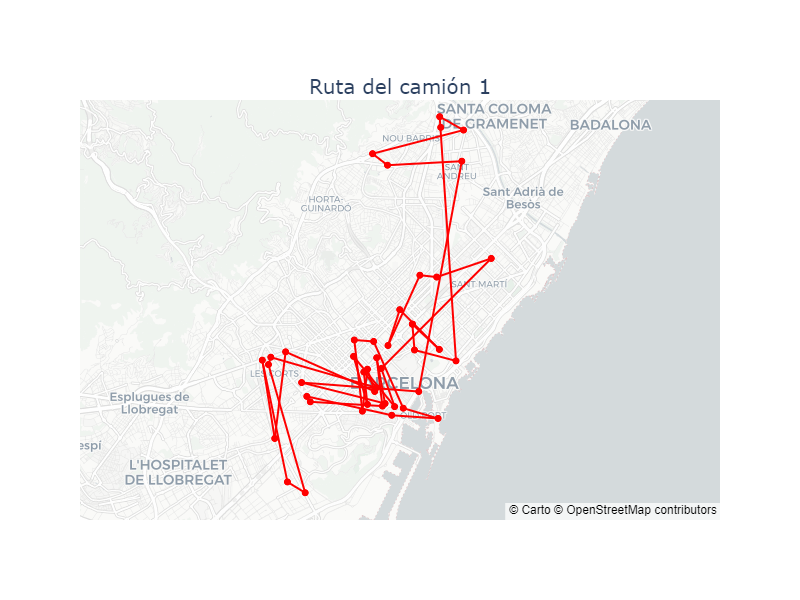

In [13]:
fig = graficar_rutas_camiones(todas_localizaciones, zoom = 11, ancho=800, alto=600)
# fig.write_image("rutas_camiones.png")
# fig.show()

static_image = pio.to_image(fig, format="png", engine="kaleido")
Image(static_image) # Muestra la imagen estática